In [1]:
import os

import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize

class FetalPlaneDataset(Dataset):
    """Fetal Plane dataset."""

    def __init__(self,
                root_dir,
                csv_file,
                transform=None,
                split='train'
                ):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
            split (string, optional): Which part of the dataset are we using (train or test)
        """
        self.transform = transform
        self.root_dir = root_dir
        self.df = pd.read_csv(csv_file, sep=';')
        self.split = split
        
        # Which dataset split are using? Training or test?
        if self.split == "train":
            self.df = self.df[self.df['Train'] == 1]
        elif self.split == "test":
            self.df = self.df[self.df['Train'] == 0]
        
        # Define classes and give each int labels
        self.plane_classes = {
            'Other' : 0, 
            'Maternal cervix' : 1, 
            'Fetal abdomen' : 2, 
            'Fetal brain' : 3, 
            'Fetal femur' : 4, 
            'Fetal thorax' : 5,
        }
        self.brain_plane_classes = {
            'Not A Brain' : 0, 
            'Trans-thalamic' : 1, 
            'Trans-cerebellum' : 2, 
            'Trans-ventricular' : 3, 
            'Other' : 4
        }
        self.operator_classes = {
            'Other' : 0, 
            'Op. 1' : 1, 
            'Op. 3' : 2, 
            'Op. 2' : 3
        }
        self.machine_classes = {
            'Aloka' : 0, 
            'Other' : 1, 
            'Voluson E6' : 2, 
            'Voluson S10' : 3
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load the image from file
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0] + '.png')
        image = Image.open(img_name)

        # Preprocess and augment the image
        if self.transform:
            image = self.transform(image)

        # Return labels for classification task
        plane_cls = self.plane_classes[self.df['Plane'].iloc[idx]]
        brain_plane_cls = self.brain_plane_classes[self.df['Brain_plane'].iloc[idx]]
        operator_cls = self.operator_classes[self.df['Operator'].iloc[idx]]
        machine_cls = self.machine_classes[self.df['US_Machine'].iloc[idx]]
        
        # Return batch
        return image, plane_cls, brain_plane_cls, operator_cls, machine_cls

In [2]:
import torchvision.transforms as transforms

# Define the transformations
transform = transforms.Compose([
    transforms.Resize(512),  # Resize shortest side to 512
    transforms.CenterCrop(512),  # Center crop to 512x512 (if you want center crop first)
    #transforms.RandomCrop(512),  # Then random crop (if image is larger)
    transforms.RandomHorizontalFlip(p=0.5),  # Mirror around y-axis
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])


In [3]:
# Define dataset objects
dataset = FetalPlaneDataset(
    './Images',
    './FETAL_PLANES_DB_data.csv',
    transform,
    'train'
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

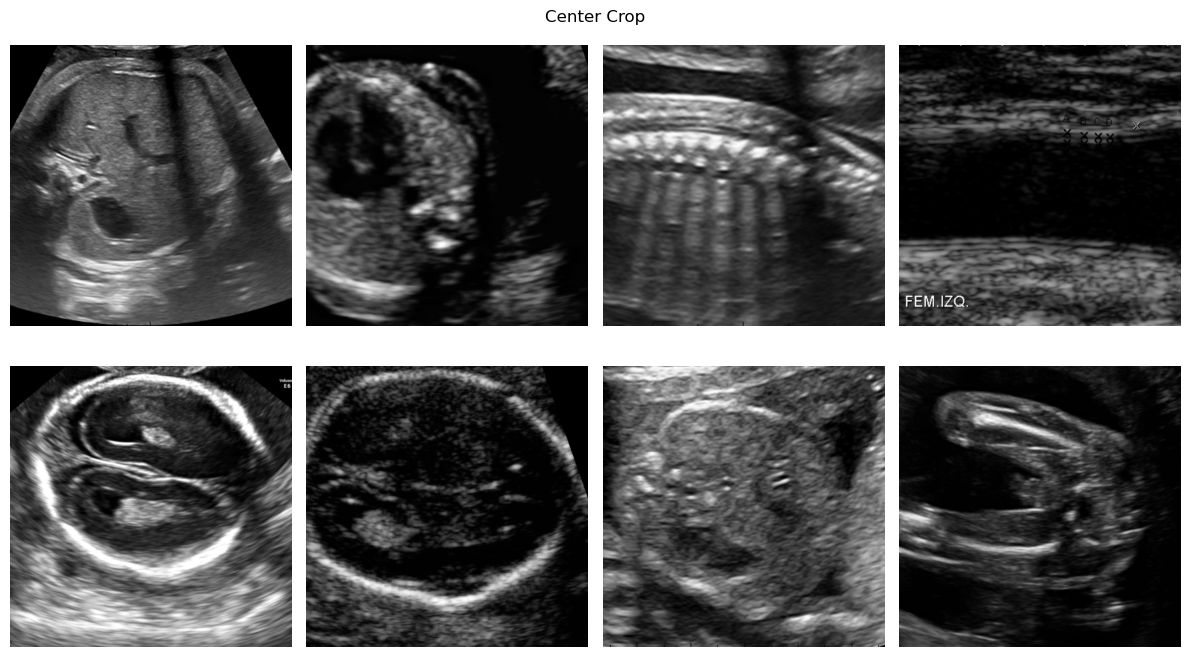

In [4]:
import matplotlib.pyplot as plt
import random

torch.manual_seed(41)
np.random.seed(41)
random.seed(41)

# Retieve data
batch = next(iter(dataloader))

# Plot example images
fig, axes = plt.subplots(2, 4, figsize=(12, 7))
for i, ax in enumerate(axes.flat):
    ax.imshow(batch[0][i,0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
fig.suptitle('Center Crop')
plt.show()

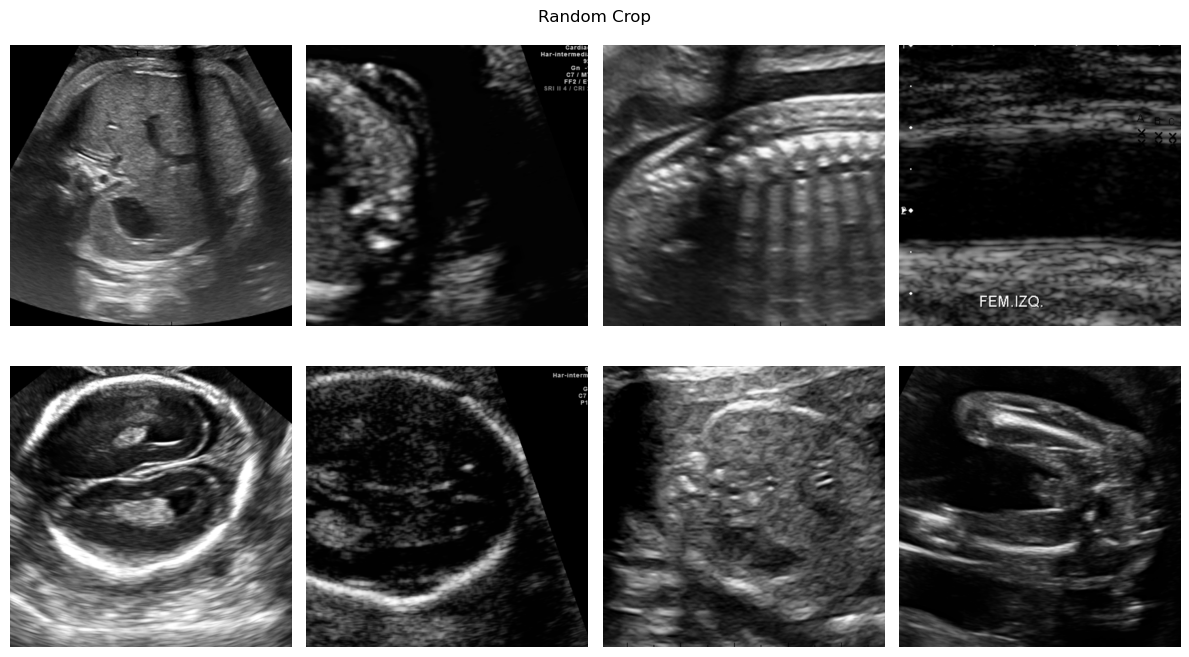

In [152]:
import matplotlib.pyplot as plt
import random

torch.manual_seed(41)
np.random.seed(41)
random.seed(41)

# Retieve data
batch = next(iter(dataloader))

# Plot example images
fig, axes = plt.subplots(2, 4, figsize=(12, 7))
for i, ax in enumerate(axes.flat):
    ax.imshow(batch[0][i,0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
fig.suptitle('Random Crop')
plt.show()